In [ ]:
"""LCR+PID_(Z & theta vs freq) @ temp"""
from Functions_A import *
from Functions_B import *
import datetime
import matplotlib.pyplot as plt
start_runtime = time.time()

# connect to the LCR meter 
ser_lcr = DeviceConnect('/dev//cu.usbserial-A94IP9Y2')  # LCR Meter
ser_cn740 = DeviceConnect_CN740('/dev/cu.usbserial-BG00XWYD')  # Omega CN740 (RS-485)

set_temp = 80 # SV in degC
PIDcommander(ser_cn740, 0x4701, set_temp*10)
PIDcommander(ser_cn740, 0x4719, 1)  # RUN
time.sleep(1) ################################### ADJUST ##############################

freq = Frequencies(10*1000, 100*1000, 100) # start, stop, number of points in-between (log spaced) 
# 10 Hz - 100 kHz (2 - 5 in log space) 

# mainReadings = ["R", "C", "L", "Z"]   (Ohm, H, C, Ohm) 
# minorReadings = ["X", "D", "Q", "THR" (θ), "ESR"] (Ohm, None, None, deg, Ohm) 
mainReadings = ['Z'] # can add multiple readings
minorReadings = ['THR'] # can add multiple readings
voltage = 1 # AC voltage (V)
biasVoltage = 0 # DC bias voltage. set to None if no bias is needed. 
numMeasurements = 5

#chamber v7.3 dimensions
height = 34 # mm
ir = 4.1 # mm
area = np.pi*ir**2 # mm^2     
area = round(area, 2)
thickness = height  # mm
material = 'paraffin wax'

try:    
    # material = input('Material? ')
    dataFrame = Experiment3(ser_lcr, freq, mainReadings, minorReadings, voltage, biasVoltage, numMeasurements, ser_cn740)
    params = [material, mainReadings, minorReadings]
    tt = dataFrame['PV'].mean()
    info = f'{area}, Area (mm^2), {thickness}, Thickness (mm), {voltage}, V, n={numMeasurements}, avg. temp = {tt}degC'
    DataExport3(params, dataFrame, info)

except Exception as e:
    print(f'Test Aborted: {e}')
    if 'dataFrame' in locals():
        info = f'{area}, Area (mm^2), {thickness}, Thickness (mm), {voltage}, V, n={numMeasurements}, avg. temp = {tt}degC'
        DataExport3(params, dataFrame, info)
        print("!!! Partial data saved.")

finally:
    DeviceDisconnect(ser_lcr)

end_runtime = time.time()
print(f"Total runtime = {round(end_runtime - start_runtime, 2)} seconds")

# LCRCommander(ser_lcr, 'SYST:REM') # remote mode 
# LCRCommander(ser_lcr, 'SYST:LOC') # local mode 

    Frequency    PV    SV      Z Avg.        Z Std.  Z-THR Avg.  Z-THR Std.
0       10000  24.5  80.0  12011592.0  5.407319e+06   -95.46950    2.875890
1       10235  24.5  80.0  14323580.0  1.945758e+05   -94.18014    0.096026
2       10476  24.5  80.0  13907140.0  1.595873e+05   -94.23848    0.024888
3       10723  24.5  80.0  13500320.0  1.671925e+05   -94.25422    0.073510
4       10975  24.5  80.0  13102060.0  1.516287e+05   -94.29272    0.039305
..        ...   ...   ...         ...           ...         ...         ...
95      91116  24.5  80.0   1324962.0  1.459769e+04  -100.78380    0.018862
96      93260  24.5  80.0   1290832.0  1.358708e+04  -100.83620    0.025246
97      95455  24.5  80.0   1258634.0  1.270507e+04  -100.93460    0.045702
98      97701  24.5  80.0   1229212.0  1.153045e+04  -101.07960    0.034109
99     100000  24.5  80.0   1201326.0  1.111366e+04  -101.25380    0.096570

[100 rows x 7 columns]
Test completed


Total runtime = 183.83 seconds


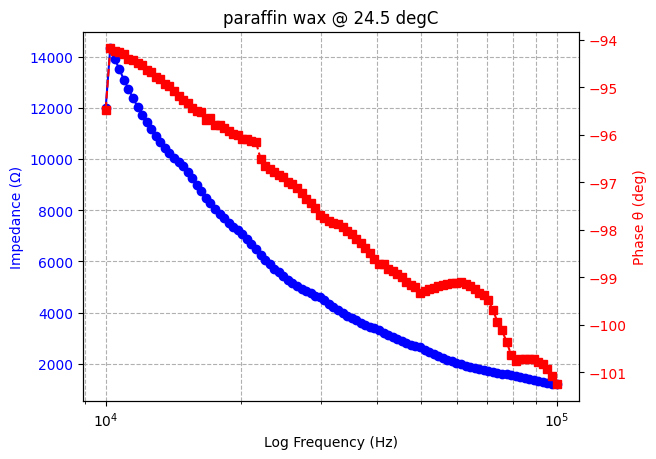

In [11]:
fig, ax1 = plt.subplots()

# Left Y-axis (Major param)
ax1.plot(dataFrame['Frequency'], dataFrame['Z Avg.']/1000, 
         marker='o', linestyle='-', color='blue', label='Impedance (kΩ)')
ax1.set_xlabel('Log Frequency (Hz)')
ax1.set_ylabel('Impedance (Ω)', color='blue')
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.ticklabel_format(style='plain', axis='y')

# Right y-axis (Minor param)
ax2 = ax1.twinx()
ax2.plot(dataFrame['Frequency'], dataFrame['Z-THR Avg.'], 
         marker='s', linestyle='--', color='red', label='Phase θ (deg)')
ax2.set_ylabel('Phase θ (deg)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.grid(True, which='both', ls='--')
plt.title(f'{material} @ {tt} degC')
plt.show()

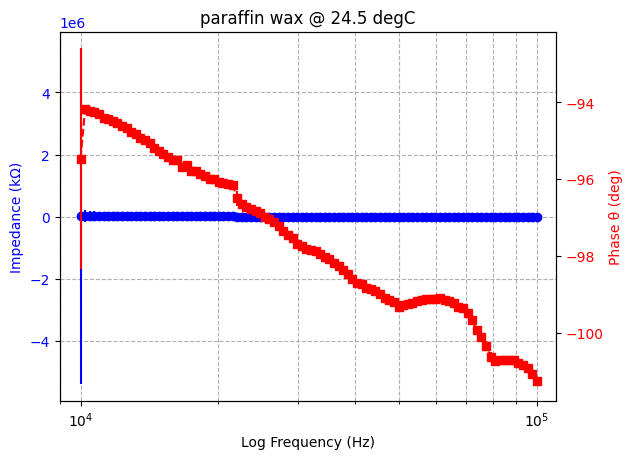

In [13]:
fig, ax1 = plt.subplots()

# Left Y-axis (Major param)
ax1.errorbar(
    dataFrame['Frequency'], dataFrame['Z Avg.']/1000, yerr=dataFrame['Z Std.'],
    fmt='o-', color='blue')
ax1.set_xlabel('Log Frequency (Hz)')
ax1.set_ylabel('Impedance (kΩ)', color='blue')
ax1.set_xscale('log')
ax1.set_xlim(freq[0]*0.9, freq[-1]*1.1)
ax1.tick_params(axis='y', labelcolor='blue')

# Right y-axis (Minor param)
ax2 = ax1.twinx()
ax2.errorbar(
    dataFrame['Frequency'], dataFrame['Z-THR Avg.'], yerr=dataFrame['Z-THR Std.'],
    fmt='s--', color='red')
ax2.set_ylabel('Phase θ (deg)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 
ax1.grid(True, which='both', ls='--')
plt.title(f'{material} @ {tt} degC')
plt.show()